# Benchmark structural regression 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker

In [2]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"

In [3]:
### parse trace files
def parse_trace(result_dir):
    f = os.path.basename(result_dir)
    name_trace = ".command.trace"
    trace = join(result_dir, name_trace)
    df = pd.read_csv(trace, sep = "=").T
    df = df.rename(index={'nextflow.trace/v2': f})
    return(df)

def split_name(df):
    df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
               "master_msa", "master_batch",
               "slave_msa", "slave_batch","tree"]] = df.name.str.split(".", expand = True)
    return(df)


### Collect all computation files across directories 
def get_computation_times(evaluation_dir, dataset, task, extralevel = False, splitname =False):
    # Extract trace files w/ corresponding alignments
    traces = pd.DataFrame()
    alignments_dir = join(evaluation_dir,task)
    for fam in listdir(alignments_dir):
        family_dir=join(alignments_dir, fam)
        
        # remove extra level if needed
        if extralevel == False:
            family_dir = alignments_dir
            
        for f in listdir(family_dir):
            result_dir = join(family_dir,f)
            if(os.path.isdir(result_dir)):
                df = parse_trace(result_dir)
                traces = traces.append(df)
                
        if extralevel == False:
            break
    # Trace files parsed
    traces = traces.reset_index(level=0)
    traces = traces.rename(columns={'index': 'name'})
    traces["benchmarking_dataset"] = dataset
    if splitname: 
        traces = split_name(traces)
    
    traces["task"] = task
    return(traces)

In [26]:
def add_families(trees_traces):
    trees_traces["family"] = trees_traces.name.str.split(".",expand=True)[0]
    trees_traces["tree_method"] = trees_traces.name.str.split(".",expand=True)[1]
    return(trees_traces)

#### Load datasets informations (Homfam + extHomfam)

In [4]:
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,benchmarking_dataset
0,rvp,combined,93681,94.288554,22,133,rvp,xlarge,0.006405,homfam
1,zf-CCHH,combined,88345,23.251265,12,35,zf-CCHH,xlarge,0.016979,homfam


# <div style="text-align: center;"> <span align="center" style="color:blue">_________TREES_________</span> </div>


In [6]:
trees_traces_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "trees", extralevel=True, splitname=False)
trees_traces_homfam = add_families(trees_traces_homfam)

trees_traces_exthomfam_v35 = get_computation_times(join(evaluation_dir, "extHomfam_v35-uniprot"), "extHomfam_v35-uniprot", "trees", extralevel=True, splitname=False)
trees_traces_exthomfam_v35 = add_families(trees_traces_exthomfam_v35)

trees_traces = pd.concat([trees_traces_homfam, trees_traces_exthomfam_v35])

stat_trees = pd.merge(trees_traces, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stat_trees.head(2)

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,family,tree_method,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,il8.FAMSA-parttree,81,600,138715,30817,142,22,1024000,32768,0,...,il8,FAMSA-parttree,combined,1073,63.762349,18,82,il8,small,1.025163
1,il8.FAMSA-medoid,379,829,138725,30822,142,22,1024000,32768,0,...,il8,FAMSA-medoid,combined,1073,63.762349,18,82,il8,small,1.025163


In [7]:
# Remove outliers for visualization 
stat_trees_nooutlier = stat_trees.sort_values(by=['realtime'], ascending=False).iloc[12:]
stat_trees_nooutlier = stat_trees_nooutlier.sort_values(by=['realtime'])
outliers = stat_trees.sort_values(by=['realtime'], ascending=False).iloc[:12]
#outliers.size_group

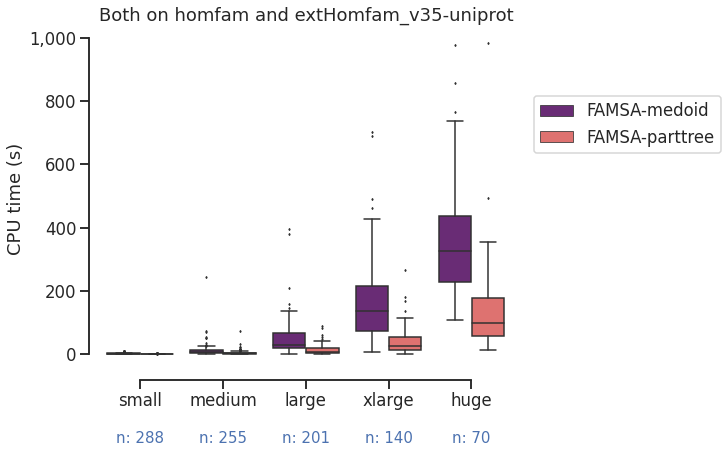

In [8]:

sns.set_theme(style="ticks")
sns.set_context("talk")

# Load the example tips dataset
f, ax = plt.subplots(figsize=(10, 7))
df = stat_trees_nooutlier
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="size_group", y="realtime",
            hue="tree_method", palette = "magma",
            data=df, linewidth=1.5, fliersize = 1.5, dodge = True)

# Calculate number of obs per group & median to position labels
nobs = df['size_group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            -280000,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='b')
 


ax.set(ylabel='CPU time (s)', xlabel='', title = "Both on homfam and extHomfam_v35-uniprot")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

sns.despine(offset=10, trim=True)


ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) ))
plt.subplots_adjust(right=0.70, bottom = 0.20)
plt.savefig(os.path.join(outdir, "10_treesCPU.pdf"))

In [966]:
#stat_trees[stat_trees.realtime == max(stat_trees.realtime)]

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,family,tree_method,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
823,transket_pyr.FAMSA-medoid,303846676,2,28024387,4341395,3546,22,96014824448,4341760,1,...,transket_pyr,FAMSA-medoid,combined,144526,168.60138,26,288,transket_pyr,xlarge,0.002076


In [369]:
#f, ax = plt.subplots(figsize=(7, 7))
#sns.scatterplot(data=stat_trees, y="realtime", x="n_sequences", hue="tree_method",
#                palette = "magma",style = "benchmarking_dataset", s = 30)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.set(ylabel='CPU time (s)', xlabel='number of sequences')
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) ))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000)+"K" ))

# <div style="text-align: center;"> <span align="center" style="color:red">_________Computation times_________</span> </div>

In [5]:
def extract_all_traces(dataset):
    # ---------- EXTRACT SEQUENCES ---------------
    #traces_extracted_sequences_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "seqs_extracted")
    # ---------- AF2 PREDICTIONS -------------------------
    # traces_af2_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "structures/colabfold")
    # ---------- ALIGNMENTS -------------------------
    traces_alignments_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "alignments", extralevel=True)
    # ---------- CONCATENATE AL OF THEM IN ONE ---------------
    traces = pd.concat([traces_alignments_homfam], ignore_index=True)
    return(traces)

In [6]:
traces = extract_all_traces("homfam")
traces.name.str.split(".", expand = True)[1].value_counts()

regressive     95
dynamic        56
progressive    33
Name: 1, dtype: int64

# <div style="text-align: center;"> <span align="center" style="color:balck">_________Load Evaluation_________</span> </div>

In [7]:
# Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")

In [8]:
dataset = "homfam"
my_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/CSV/")

In [12]:
def get_evaluation(my_dir, csv_file, splitname = True):
    
    scores = join(my_dir, csv_file)    
    scores_df = pd.read_csv(scores, sep=";", header = None).iloc[: , :-1]
    scores_df.set_axis(list(["name", "sp","tc", "column"]), axis=1, inplace=True)
    
    method = csv_file.split(".")[0]

    
    if splitname:
        if method == "dynamic": 
            scores_df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
                       "master_msa", 
                       "slave_msa","tree"]] = scores_df.name.str.split(".", expand = True)
        elif method == "regressive":
            scores_df[["family", "method", "bucket_size",
                       "master_msa","tree"]] = scores_df.name.str.split(".", expand = True)
        elif method == "progressive":
            scores_df[["family", "method",
                       "master_msa","tree"]] = scores_df.name.str.split(".", expand = True)        
    scores_df["benchmarking_dataset"] = dataset
    #scores_df.master_msa = scores_df.master_msa.str.split("_")[0]
    #scores_df.master_msa = scores_df.master_msa.apply(lambda x: x.astype(str).str.upper())
    scores_df = scores_df.reset_index()
    return(scores_df)

def get_evaluation_all(my_dir):
    all_files = os.listdir(my_dir)    
    csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))
    df  = pd.DataFrame()
    for file in csv_files: 
        df = pd.concat(list([df, get_evaluation(my_dir, file)]))
    return(df)    

In [13]:
scores_df = get_evaluation_all(my_dir)
scores_df["bucket_size"] = pd.to_numeric(scores_df.bucket_size)
scores_df.method.value_counts()

dynamic        56
regressive     15
progressive    15
Name: method, dtype: int64

# <div style="text-align: center;"> <span align="center" style="color:lightgrey">_________MERGE_________</span> </div>

In [11]:
stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stats.head()
traces.head(2)

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,vmem,rss,peak_vmem,peak_rss,vol_ctxt,inv_ctxt,benchmarking_dataset,task
0,il8.regressive.50.FAMSA.FAMSA-medoid,3644,2645,28300827,2801672,16642,2034,3794944,4374528,0,294936,203584,294956,203584,132,19,homfam,alignments
1,LIM.progressive.FAMSA.FAMSA-medoid,814,875,748881,3407163,219,436,1641472,3407872,0,1126036,43240,1191576,43796,40,13,homfam,alignments


# <div style="text-align: center;"> <span align="center" style="color:blue">_________VISUALIZE_________</span> </div>

In [14]:
stats_alignments = stats[stats.task == "alignments"]

In [15]:
stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [16]:
stats_alignments.approach = stats_alignments.approach.str.replace("_nan", "")
stats_alignments["diff_tc"]= 100 - stats_alignments["tc"]
stats_alignments["diff_sp"]= 100 - stats_alignments["sp"]
stats_alignments["diff_column"]= 100 - stats_alignments["column"]

In [17]:
stats_alignments

,index,name,sp,tc,column,family,method,bucket_size,master_msa,tree,...,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,diff_tc,diff_sp,diff_column
0,0,OTCace.regressive.50.FAMSA.FAMSA-medoid,93.9,83.1,85.9,OTCace,regressive,50.0,FAMSA,FAMSA-medoid,...,157.004588,33,335,OTCace,medium,0.104275,regressive_50.0_FAMSA,16.9,6.1,14.1
1,10,OTCace.progressive.FAMSA.FAMSA-medoid,90.0,77.4,80.7,OTCace,progressive,NaN,FAMSA,FAMSA-medoid,...,157.004588,33,335,OTCace,medium,0.104275,progressive_FAMSA,22.6,10.0,19.3
2,1,cyclo.regressive.50.FAMSA.FAMSA-medoid,61.6,35.4,34.8,cyclo,regressive,50.0,FAMSA,FAMSA-medoid,...,159.069338,31,252,cyclo,medium,0.095420,regressive_50.0_FAMSA,64.6,38.4,65.2
3,12,cyclo.progressive.FAMSA.FAMSA-medoid,85.5,68.8,70.7,cyclo,progressive,NaN,FAMSA,FAMSA-medoid,...,159.069338,31,252,cyclo,medium,0.095420,progressive_FAMSA,31.2,14.5,29.3
4,2,proteasome.regressive.50.FAMSA.FAMSA-medoid,78.9,31.7,41.6,proteasome,regressive,50.0,FAMSA,FAMSA-medoid,...,174.347348,27,250,proteasome,medium,0.296581,regressive_50.0_FAMSA,68.3,21.1,58.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,44,scorptoxin.dynamic.50.dynamicX.100000000.famsa...,93.1,76.7,86.3,scorptoxin,dynamic,50.0,famsa_msa,FAMSA-medoid,...,53.256198,22,69,scorptoxin,small,2.203857,dynamic_50.0_famsa_msa_famsa_msa_100000000,23.3,6.9,13.7
82,29,hip.dynamic.50.dynamicX.1.famsa_msa.famsa_msa....,86.3,64.3,72.8,hip,dynamic,50.0,famsa_msa,FAMSA-medoid,...,66.209581,54,85,hip,small,2.994012,dynamic_50.0_famsa_msa_famsa_msa_1,35.7,13.7,27.2
83,42,hip.dynamic.50.dynamicX.1.tcoffee_msa.famsa_ms...,78.7,44.0,55.9,hip,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,66.209581,54,85,hip,small,2.994012,dynamic_50.0_tcoffee_msa_famsa_msa_1,56.0,21.3,44.1
84,43,hip.dynamic.50.dynamicX.100000000.tcoffee_msa....,78.7,44.0,55.9,hip,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,66.209581,54,85,hip,small,2.994012,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,56.0,21.3,44.1


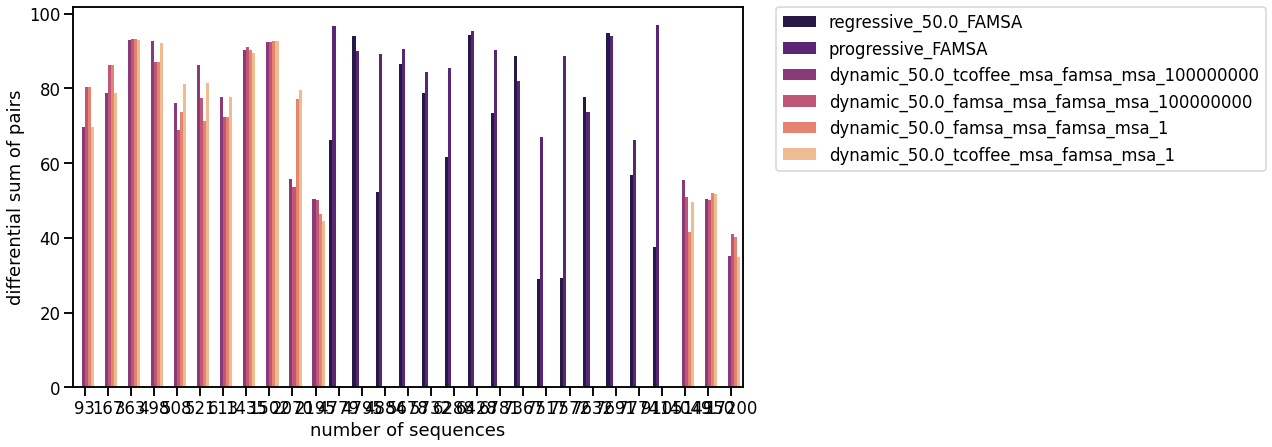

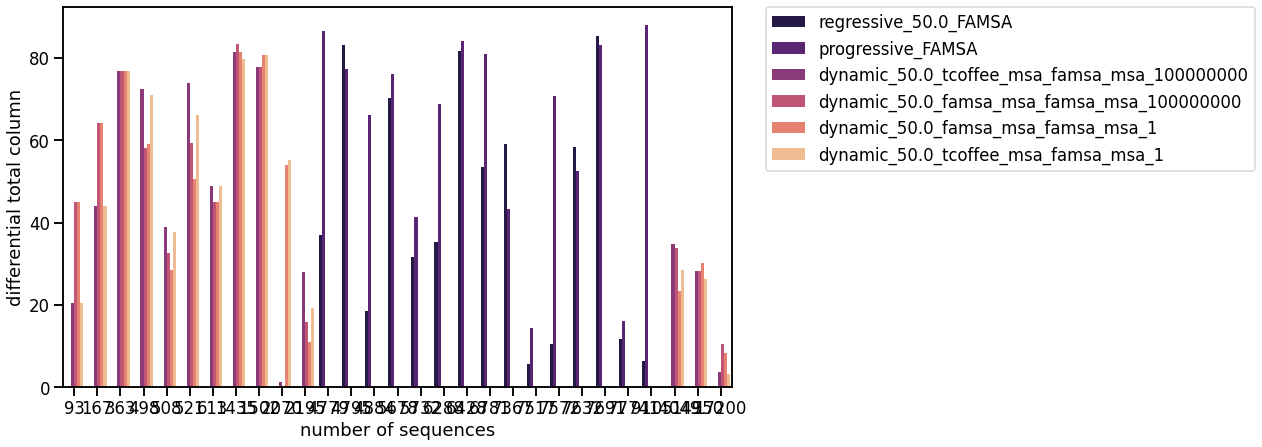

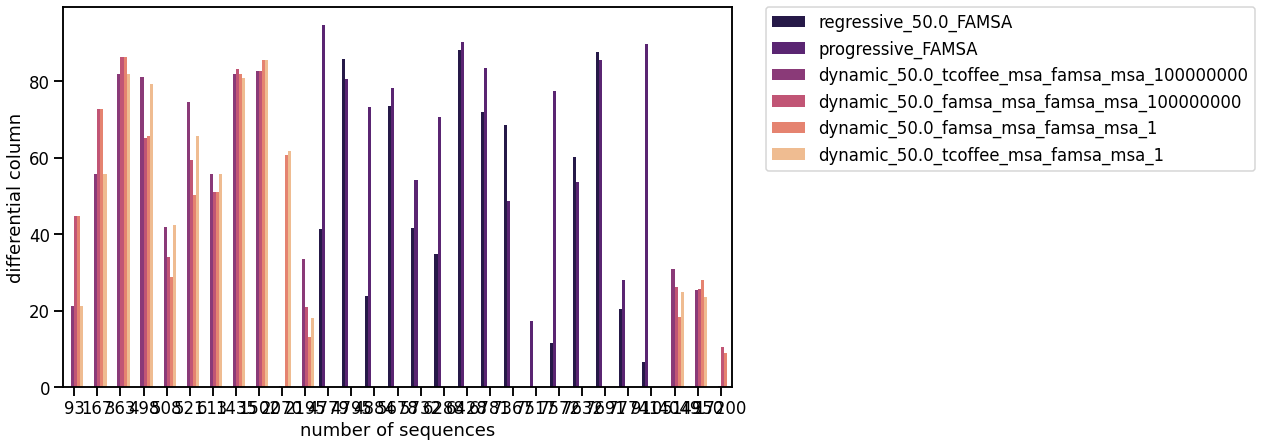

In [22]:
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
sns.set_context("talk")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]
#metrics = [["diff_sp", "sum of pairs"], ["diff_tc", "total column"], ["diff_column", "column"]]

for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(data=stats_alignments, y=metric[0], x="n_sequences", hue="approach",
                    palette = "magma")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel= "differential " + metric[1], xlabel='number of sequences')

In [293]:
stats_alignments[stats_alignments.family == "seatoxin"]

,index,name,sp,tc,column,family,method,bucket_size,master_msa,tree,...,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,diff_tc,diff_sp,diff_column
60,10,seatoxin.regressive.50.FAMSA.FAMSA-medoid,80.3,44.9,44.7,seatoxin,regressive,50.0,FAMSA,FAMSA-medoid,...,43.634409,34,50,seatoxin,small,5.376344,regressive_50.0_FAMSA,55.1,19.7,55.3
61,10,seatoxin.progressive.FAMSA.FAMSA-medoid,80.1,46.9,47.0,seatoxin,progressive,NaN,FAMSA,FAMSA-medoid,...,43.634409,34,50,seatoxin,small,5.376344,progressive_FAMSA,53.1,19.9,53.0
62,4,seatoxin.dynamic.50.dynamicX.100000000.tcoffee...,69.7,20.4,21.3,seatoxin,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,43.634409,34,50,seatoxin,small,5.376344,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,79.6,30.3,78.7
63,35,seatoxin.dynamic.50.dynamicX.1.famsa_msa.famsa...,80.3,44.9,44.7,seatoxin,dynamic,50.0,famsa_msa,FAMSA-medoid,...,43.634409,34,50,seatoxin,small,5.376344,dynamic_50.0_famsa_msa_famsa_msa_1,55.1,19.7,55.3
64,38,seatoxin.dynamic.50.dynamicX.1.tcoffee_msa.fam...,69.7,20.4,21.3,seatoxin,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,43.634409,34,50,seatoxin,small,5.376344,dynamic_50.0_tcoffee_msa_famsa_msa_1,79.6,30.3,78.7
65,46,seatoxin.dynamic.50.dynamicX.100000000.famsa_m...,80.3,44.9,44.7,seatoxin,dynamic,50.0,famsa_msa,FAMSA-medoid,...,43.634409,34,50,seatoxin,small,5.376344,dynamic_50.0_famsa_msa_famsa_msa_100000000,55.1,19.7,55.3


In [26]:
stats_alignments_progressive = stats_alignments[stats_alignments.method == "progressive"]


stats_alignments_50 = stats_alignments.loc[stats_alignments['bucket_size'].isin(list([50]))]
stats_alignments_regressive = stats_alignments_50[stats_alignments_50.method == "regressive"]

stats_alignments_dynamic = stats_alignments[stats_alignments.method == "dynamic"][stats_alignments.dynamicX_val =="1"]
stats_alignments_dynamic_famsa = stats_alignments_dynamic[stats_alignments_dynamic.master_msa == "famsa_msa" ]
stats_alignments_dynamic_3d = stats_alignments_dynamic[stats_alignments_dynamic.master_msa == "tcoffee_msa" ]


/tmp/ipykernel_10484/925751843.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stats_alignments_dynamic = stats_alignments[stats_alignments.method == "dynamic"][stats_alignments.dynamicX_val =="1"]


In [27]:
stats_alignments[stats_alignments.method == "dynamic"]

,index,name,sp,tc,column,family,method,bucket_size,master_msa,tree,...,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,diff_tc,diff_sp,diff_column
30,0,toxin.dynamic.50.dynamicX.100000000.tcoffee_ms...,76.1,39.0,42.0,toxin,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,62.311024,30,77,toxin,small,3.937008,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,61.0,23.9,58.0
31,5,toxin.dynamic.50.dynamicX.100000000.famsa_msa....,68.9,32.5,34.0,toxin,dynamic,50.0,famsa_msa,FAMSA-medoid,...,62.311024,30,77,toxin,small,3.937008,dynamic_50.0_famsa_msa_famsa_msa_100000000,67.5,31.1,66.0
32,12,toxin.dynamic.50.dynamicX.1.famsa_msa.famsa_ms...,73.7,28.6,28.8,toxin,dynamic,50.0,famsa_msa,FAMSA-medoid,...,62.311024,30,77,toxin,small,3.937008,dynamic_50.0_famsa_msa_famsa_msa_1,71.4,26.3,71.2
33,34,toxin.dynamic.50.dynamicX.1.tcoffee_msa.famsa_...,81.3,37.7,42.5,toxin,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,62.311024,30,77,toxin,small,3.937008,dynamic_50.0_tcoffee_msa_famsa_msa_1,62.3,18.7,57.5
34,1,GEL.dynamic.50.dynamicX.100000000.tcoffee_msa....,50.4,28.1,33.6,GEL,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,78.115718,27,127,GEL,small,0.227790,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,71.9,49.6,66.4
35,2,GEL.dynamic.50.dynamicX.1.tcoffee_msa.famsa_ms...,44.4,19.2,18.0,GEL,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,78.115718,27,127,GEL,small,0.227790,dynamic_50.0_tcoffee_msa_famsa_msa_1,80.8,55.6,82.0
36,23,GEL.dynamic.50.dynamicX.100000000.famsa_msa.fa...,50.1,15.8,21.1,GEL,dynamic,50.0,famsa_msa,FAMSA-medoid,...,78.115718,27,127,GEL,small,0.227790,dynamic_50.0_famsa_msa_famsa_msa_100000000,84.2,49.9,78.9
37,37,GEL.dynamic.50.dynamicX.1.famsa_msa.famsa_msa....,46.3,11.0,13.2,GEL,dynamic,50.0,famsa_msa,FAMSA-medoid,...,78.115718,27,127,GEL,small,0.227790,dynamic_50.0_famsa_msa_famsa_msa_1,89.0,53.7,86.8
38,3,rub.dynamic.50.dynamicX.1.tcoffee_msa.famsa_ms...,89.6,79.6,80.8,rub,dynamic,50.0,tcoffee_msa,FAMSA-medoid,...,46.157491,20,57,rub,small,0.348432,dynamic_50.0_tcoffee_msa_famsa_msa_1,20.4,10.4,19.2
39,21,rub.dynamic.50.dynamicX.1.famsa_msa.famsa_msa....,90.4,81.5,82.0,rub,dynamic,50.0,famsa_msa,FAMSA-medoid,...,46.157491,20,57,rub,small,0.348432,dynamic_50.0_famsa_msa_famsa_msa_1,18.5,9.6,18.0


In [28]:
variables = ['method', 'family', "master_msa", 'bucket_size', 'tc']

In [29]:
def get_relative_tc(stats_alignments_dynamic, stats_alignments_regressive = stats_alignments_regressive):
    # sort dataframes 
    dynamic_df_sorted = stats_alignments_dynamic[variables].sort_values(variables)
    regressive_df_sorted = stats_alignments_regressive[variables].sort_values(variables)

    dynamic = np.array(dynamic_df_sorted.tc)
    regressive = np.array(regressive_df_sorted.tc)
    print(dynamic)
    print(regressive)
    
    delta = dynamic - regressive
    perc_change = (dynamic - regressive)*100/dynamic

    dynamic_df_sorted["delta"] = delta
    dynamic_df_sorted["perc_change"] = perc_change

    # add family size 
    famsize = stats[list(["family", "n_sequences"])].drop_duplicates()
    dy_vs_reg = dynamic_df_sorted.sort_values(variables).merge(famsize, on=["family"])
    dy_vs_reg = dy_vs_reg.sort_values("n_sequences")
    return(dy_vs_reg)

In [30]:
stats_alignments_regressive

,index,name,sp,tc,column,family,method,bucket_size,master_msa,tree,...,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,diff_tc,diff_sp,diff_column
0,0,OTCace.regressive.50.FAMSA.FAMSA-medoid,93.9,83.1,85.9,OTCace,regressive,50.0,FAMSA,FAMSA-medoid,...,157.004588,33,335,OTCace,medium,0.104275,regressive_50.0_FAMSA,16.9,6.1,14.1
2,1,cyclo.regressive.50.FAMSA.FAMSA-medoid,61.6,35.4,34.8,cyclo,regressive,50.0,FAMSA,FAMSA-medoid,...,159.069338,31,252,cyclo,medium,0.095420,regressive_50.0_FAMSA,64.6,38.4,65.2
4,2,proteasome.regressive.50.FAMSA.FAMSA-medoid,78.9,31.7,41.6,proteasome,regressive,50.0,FAMSA,FAMSA-medoid,...,174.347348,27,250,proteasome,medium,0.296581,regressive_50.0_FAMSA,68.3,21.1,58.4
6,3,HMG_box.regressive.50.FAMSA.FAMSA-medoid,66.3,37.0,41.4,HMG_box,regressive,50.0,FAMSA,FAMSA-medoid,...,66.071563,22,86,HMG_box,medium,0.104624,regressive_50.0_FAMSA,63.0,33.7,58.6
8,4,msb.regressive.50.FAMSA.FAMSA-medoid,52.4,18.6,24.0,msb,regressive,50.0,FAMSA,FAMSA-medoid,...,106.037469,28,144,msb,medium,0.163800,regressive_50.0_FAMSA,81.4,47.6,76.0
10,5,HLH.regressive.50.FAMSA.FAMSA-medoid,73.3,53.6,72.1,HLH,regressive,50.0,FAMSA,FAMSA-medoid,...,53.545347,21,140,HLH,medium,0.073735,regressive_50.0_FAMSA,46.4,26.7,27.9
12,6,blm.regressive.50.FAMSA.FAMSA-medoid,37.6,6.4,6.6,blm,regressive,50.0,FAMSA,FAMSA-medoid,...,300.726524,27,461,blm,medium,0.087864,regressive_50.0_FAMSA,93.6,62.4,93.4
14,7,int.regressive.50.FAMSA.FAMSA-medoid,29.2,10.4,11.7,int,regressive,50.0,FAMSA,FAMSA-medoid,...,168.037242,27,274,int,medium,0.066033,regressive_50.0_FAMSA,89.6,70.8,88.3
16,8,lyase_1.regressive.50.FAMSA.FAMSA-medoid,77.7,58.3,60.2,lyase_1,regressive,50.0,FAMSA,FAMSA-medoid,...,295.081761,22,459,lyase_1,medium,0.065514,regressive_50.0_FAMSA,41.7,22.3,39.8
18,9,LIM.regressive.50.FAMSA.FAMSA-medoid,94.4,81.7,88.2,LIM,regressive,50.0,FAMSA,FAMSA-medoid,...,57.014312,24,85,LIM,medium,0.077785,regressive_50.0_FAMSA,18.3,5.6,11.8


In [31]:
pro_vs_reg = get_relative_tc(stats_alignments_progressive)
dyn3d_vs_reg = get_relative_tc(stats_alignments_dynamic_3d)


[81.  86.4 84.1 77.4 88.  68.8 16.2 83.2 76.  70.8 43.2 52.5 66.2 41.4
 14.3]
[53.6 37.  81.7 83.1  6.4 35.4 11.8 85.2 70.2 10.4 59.2 58.3 18.6 31.7
  5.6]
[19.2 55.2 26.3 28.6  3.3 80.8 66.1 44.  70.9 79.6 76.7 20.4 48.9 37.7]
[53.6 37.  81.7 83.1  6.4 35.4 11.8 85.2 70.2 10.4 59.2 58.3 18.6 31.7
  5.6]


ValueError: operands could not be broadcast together with shapes (14,) (15,) 

In [37]:
pro_vs_reg = get_relative_tc(stats_alignments_progressive)
dyn3d_vs_reg = get_relative_tc(stats_alignments_dynamic_3d)
dynfamsa_vs_reg = get_relative_tc(stats_alignments_dynamic_famsa)

# Calc differential TC 
differential_tc_vs_reg50 = pd.concat(list([pro_vs_reg,dyn3d_vs_reg,dynfamsa_vs_reg]))
differential_tc_vs_reg50["method_extended"] = differential_tc_vs_reg50.method + "_"+differential_tc_vs_reg50.master_msa+ "_" +differential_tc_vs_reg50.bucket_size.astype(str)

[81.  86.4 84.1 77.4 88.  68.8 16.2 83.2 76.  70.8 43.2 52.5 66.2 41.4
 14.3]
[53.6 37.  81.7 83.1  6.4 35.4 11.8 85.2 70.2 10.4 59.2 58.3 18.6 31.7
  5.6]
[19.2 55.2 26.3 28.6  3.3 80.8 66.1 44.  70.9 79.6 76.7 20.4 48.9 37.7]
[53.6 37.  81.7 83.1  6.4 35.4 11.8 85.2 70.2 10.4 59.2 58.3 18.6 31.7
  5.6]


ValueError: operands could not be broadcast together with shapes (14,) (15,) 

In [38]:
differential_tc_vs_reg50["method_extended"] = differential_tc_vs_reg50["method_extended"].str.replace('progressive_FAMSA_nan','FAMSA', regex = False)
differential_tc_vs_reg50["method_extended"] = differential_tc_vs_reg50["method_extended"].str.replace('dynamic_tcoffee_msa_50.0','3D-50_rFAMSA-50', regex = False)
differential_tc_vs_reg50["method_extended"] = differential_tc_vs_reg50["method_extended"].str.replace('dynamic_famsa_msa_50.0','FAMSA-50_rFAMSA-50', regex = False)

NameError: name 'differential_tc_vs_reg50' is not defined

NameError: name 'differential_tc_vs_reg50' is not defined

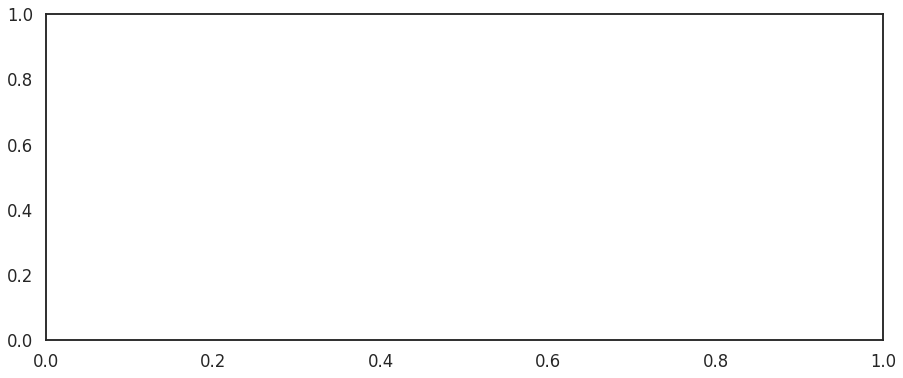

In [34]:
# Plot differential TC 
sns.set_theme(style="white", context="talk")

rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True)

# Generate some sequential data
sns.barplot(x="family", y="perc_change",data = differential_tc_vs_reg50, palette="viridis", hue = "method_extended")
ax.axhline(0, color="k", clip_on=False)


# Calculate number of obs per group & median to position labels
nobs =  dyn3d_vs_reg[list(["family", "n_sequences"])].drop_duplicates().n_sequences
nobs = [str(x) for x in nobs.tolist()]
nobs = ["#seq: \n" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            -150,
            nobs[tick],
            horizontalalignment='center',
            size='medium',
            color='b')


ax.set_ylabel("differential total column score (%)")
ax.set_title("dynamic vs regressive. reference: regressive.")
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, title= "", borderaxespad=0.)



In [204]:
stats_alignments
stats_alignments["method_extended"] = stats_alignments.method + "_"+stats_alignments.master_msa+ "_" +stats_alignments.bucket_size.astype(str)
stats_alignments["method_extended"] = stats_alignments["method_extended"].str.replace('progressive_FAMSA_nan','FAMSA', regex = False)
stats_alignments["method_extended"] = stats_alignments["method_extended"].str.replace('dynamic_tcoffee_msa_50.0','3D-50_rFAMSA-50', regex = False)
stats_alignments["method_extended"] = stats_alignments["method_extended"].str.replace('dynamic_famsa_msa_50.0','FAMSA-50_rFAMSA-50', regex = False)

/tmp/ipykernel_109934/3449464348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_alignments["method_extended"] = stats_alignments.method + "_"+stats_alignments.master_msa+ "_" +stats_alignments.bucket_size.astype(str)
/tmp/ipykernel_109934/3449464348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_alignments["method_extended"] = stats_alignments["method_extended"].str.replace('progressive_FAMSA_nan','FAMSA', regex = False)
/tmp/ipykernel_109934/3449464348.py:4: SettingWithCopyWarning: 
A

In [205]:
stats_alignments.head(2)

,index,name,sp,tc,column,family,method,bucket_size,master_msa,tree,...,task,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,method_extended
0,0,rub.regressive.50.FAMSA.FAMSA-medoid,90.4,81.5,82.0,rub,regressive,50.0,FAMSA,FAMSA-medoid,...,alignments,combined,1435,46.157491,20,57,rub,small,0.348432,regressive_FAMSA_50.0
1,10,rub.progressive.FAMSA.FAMSA-medoid,99.2,96.3,96.7,rub,progressive,NaN,FAMSA,FAMSA-medoid,...,alignments,combined,1435,46.157491,20,57,rub,small,0.348432,FAMSA


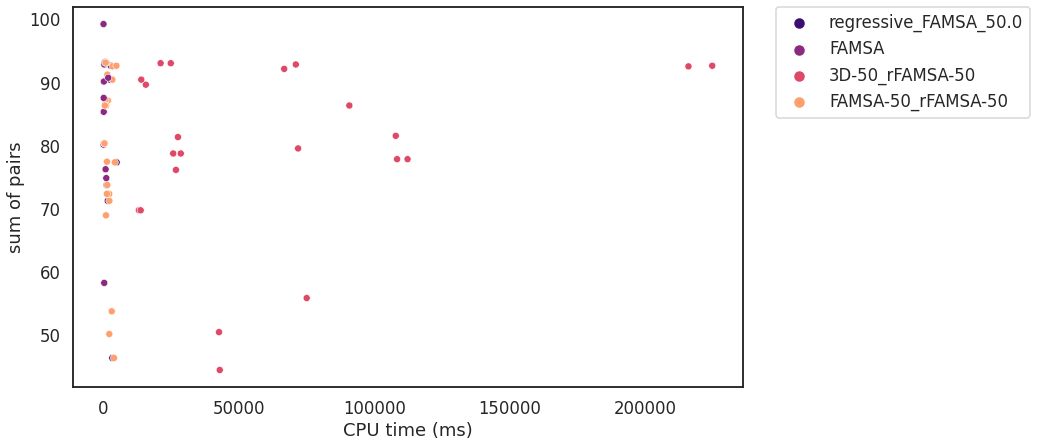

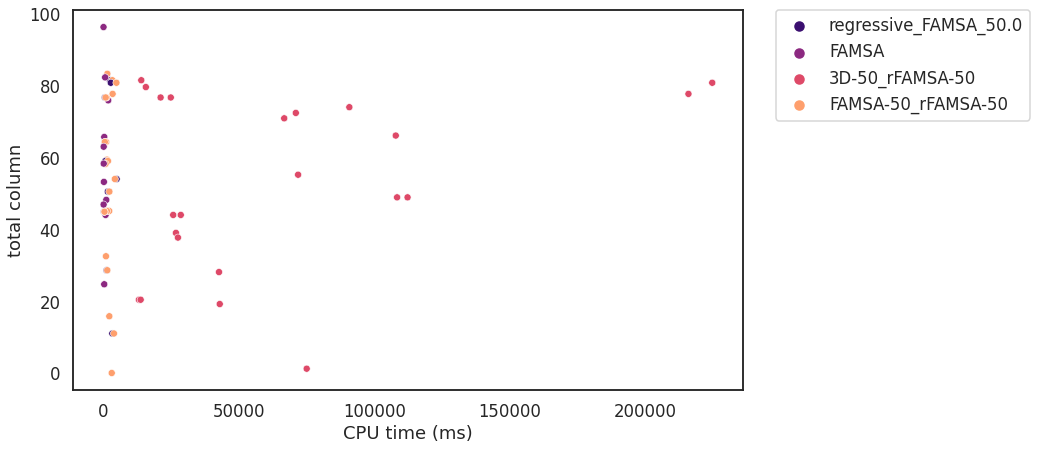

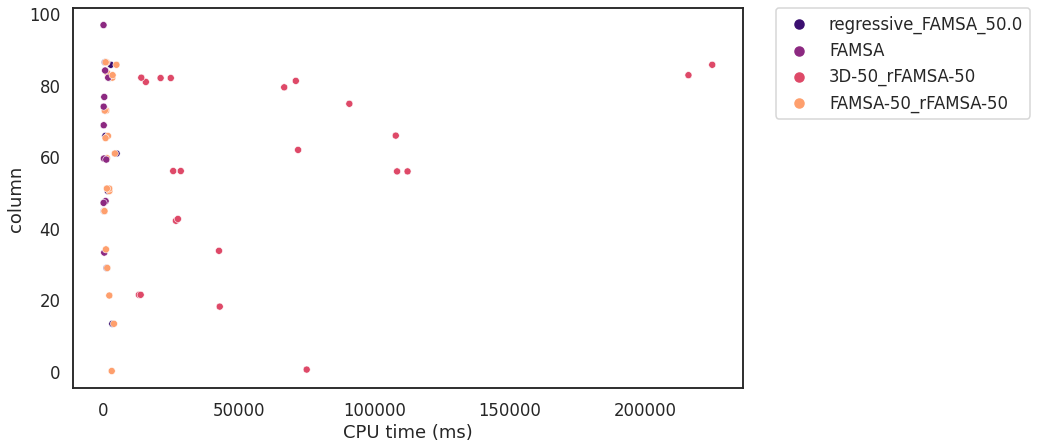

In [206]:
# 2 - At which computational loss? 
# b. plot all 3 metrics (SUM etc) vs the CPU time (aligner only) (Dynamic + Regressive on FAMSA)
sns.set_context("talk")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]

for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(data=stats_alignments, y=metric[0], x="realtime", hue="method_extended",
                    palette = "magma", s = 50)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=metric[1], xlabel='CPU time (ms)')

In [923]:
# --------------   TODO -----------------
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
# 2 - At which computational loss? 
# b. plot all 3 metrics (SUM etc) vs the CPU time (aligner only) (Dynamic + Regressive on FAMSA)
# c. plot all 3 metrics (SUM etc) vs the CPU time (aligner only AND aligner + extract + prediction) (Dynamic + Regressive on FAMSA)
# 3 - confront gain in accuracy? Accuracy Dynamic vs Accuracy regressive
# 4 - cnfront loss in speed - cpu time dynamic vs regressive

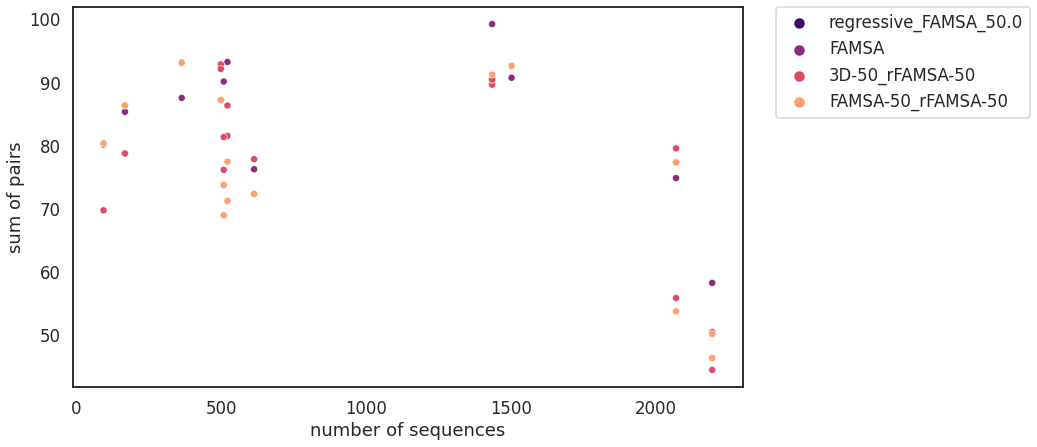

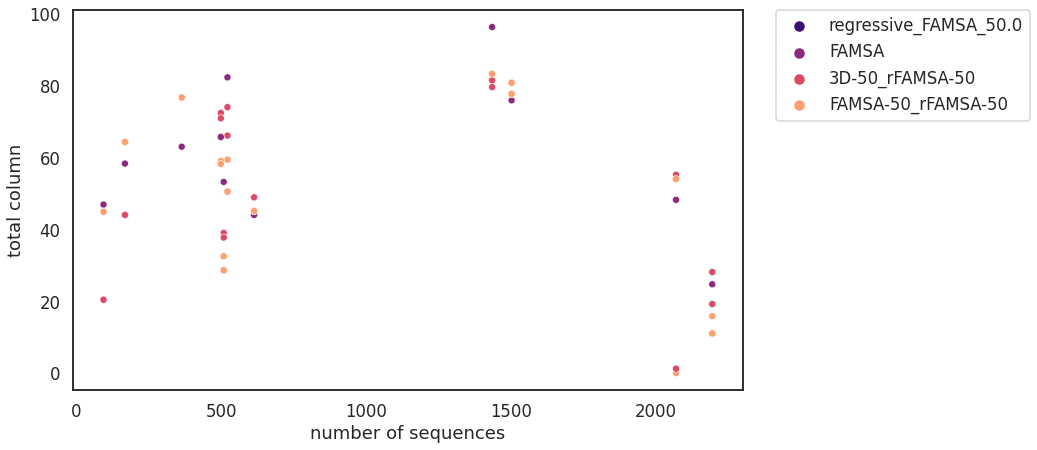

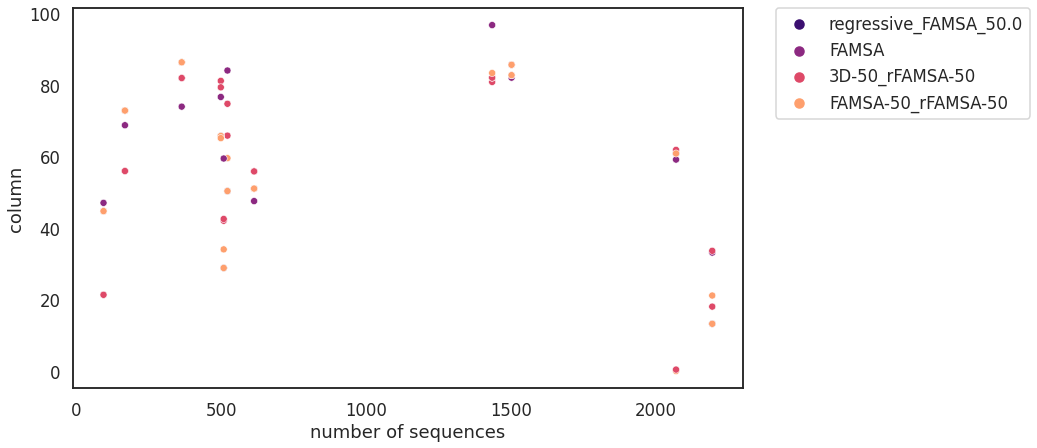

In [207]:
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
sns.set_context("talk")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]

for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(data=stats_alignments, y=metric[0], x="n_sequences", hue="method_extended",
                    palette = "magma", s = 50)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=metric[1], xlabel='number of sequences')